# Packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *
import seaborn as sns
from collections import Counter
from MCML.modules import MCML, bMCML

/mnt/c/Users/Xavier/Desktop/sc_alz/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import dataset and annotation

In [2]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
adata = anndata.read_h5ad('/mnt/c/Users/Xavier/Desktop/sc_2024_files/fede_data/_1_10m-3xTg-vs-wt-SCDi-MGI-25-000.h5ad')
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
anno_df = pd.read_csv("/mnt/c/Users/Xavier/Desktop/sc_2024_files/fede_data/_1_10m-3xTg-vs-wt-SCDi-MGI-25-000_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1718371182285.csv", skiprows=4)

In [3]:
# adata1 = anndata.read_h5ad("data/A_count.h5ad")
# adata1.obs['Sample_Tag'] = 'LD_5xFAD'
# adata2 = anndata.read_h5ad("data/B_count.h5ad")
# adata2.obs['Sample_Tag'] = "LD_NC"
# adata3 = anndata.read_h5ad("data/C_count.h5ad")
# adata3.obs['Sample_Tag'] = "run_5xFAD"
# adata4 = anndata.read_h5ad("data/D_count.h5ad")
# adata4.obs['Sample_Tag'] = "run_NC"
# adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)

# anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
# anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
# anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
# anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
# anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])

In [4]:
adata = annotate_adata(adata, anno_df)

# Data preprocessing

In [5]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

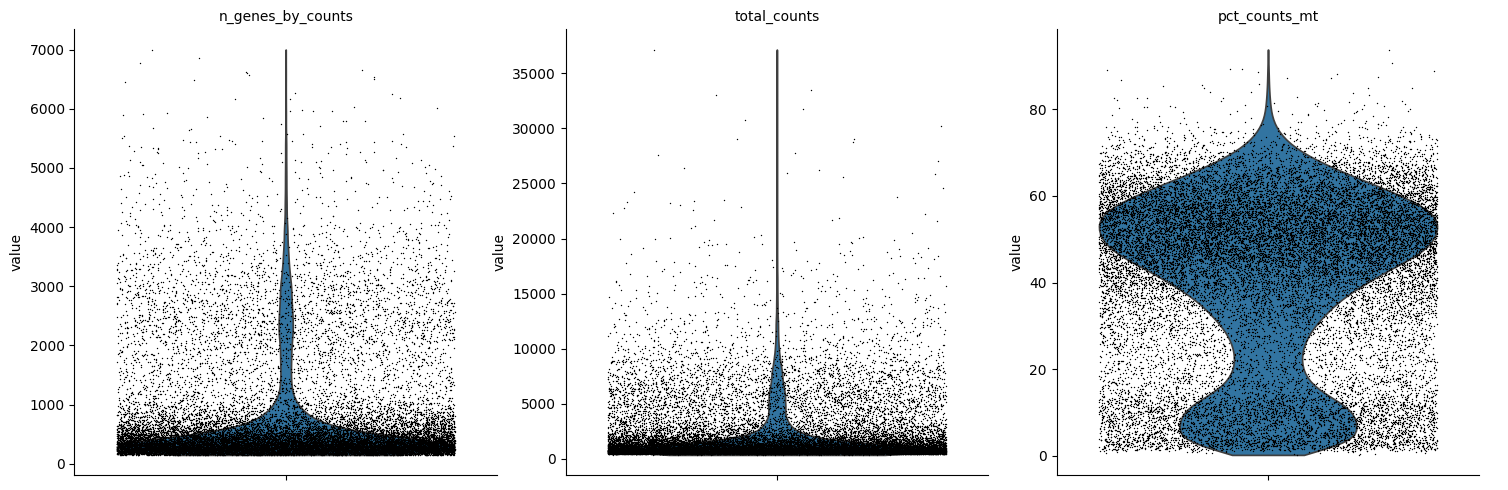

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

In [8]:
adata = adata[~adata.obs['high_mt'], :]

In [9]:
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]

In [10]:
#adata = adata[:, ~adata.var['mt']]

# Select adata object to use for analysis

In [11]:
#file_path = 'data/filtered_adata.h5ad'
#adata = anndata.read_h5ad(file_path)

In [12]:
adata.raw = adata

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata)

# Dimensionality reduction

In [ ]:
#elbow_plot(adata, save_path='figures/elbow_plot.png')

In [ ]:
#dimension_heatmap(adata, n_components=20, n_cells=500, save_path='figures/dimension_heatmap.png')

In [14]:
sc.tl.pca(adata, n_comps=10)

In [ ]:
mcml = MCML(n_latent = 50, epochs = 100)
class_name = adata.obs['class_name'].values.tolist()
sample_tag = adata.obs['Sample_Tag'].values.tolist()
latentMCML = mcml.fit(adata.X, np.array([class_name]) , fracNCA = 0.8 , silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)
adata.obsm['latents'] = latentMCML

In [ ]:
mcml = bMCML(n_latent = 50, epochs = 100)
class_name = adata.obs['class_name'].values.tolist()
sample_tag = adata.obs['Sample_Tag'].values.tolist()
latentMCML = mcml.fit(adata.X, np.array(class_name), np.array(sample_tag), silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)
adata.obsm['latents'] = latentMCML

# Batch correction

In [15]:
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

2024-06-30 19:25:35,307 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-30 19:25:37,011 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-30 19:25:37,195 - harmonypy - INFO - Iteration 1 of 10
2024-06-30 19:25:40,370 - harmonypy - INFO - Iteration 2 of 10
2024-06-30 19:25:43,319 - harmonypy - INFO - Iteration 3 of 10
2024-06-30 19:25:46,034 - harmonypy - INFO - Iteration 4 of 10
2024-06-30 19:25:48,986 - harmonypy - INFO - Iteration 5 of 10
2024-06-30 19:25:51,535 - harmonypy - INFO - Iteration 6 of 10
2024-06-30 19:25:54,196 - harmonypy - INFO - Iteration 7 of 10
2024-06-30 19:25:57,202 - harmonypy - INFO - Converged after 7 iterations


# Clustering

In [16]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=10)
sc.tl.leiden(adata, resolution=0.5)

/tmp/ipykernel_326/3450246181.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


# Visualization

In [17]:
sc.tl.umap(adata)

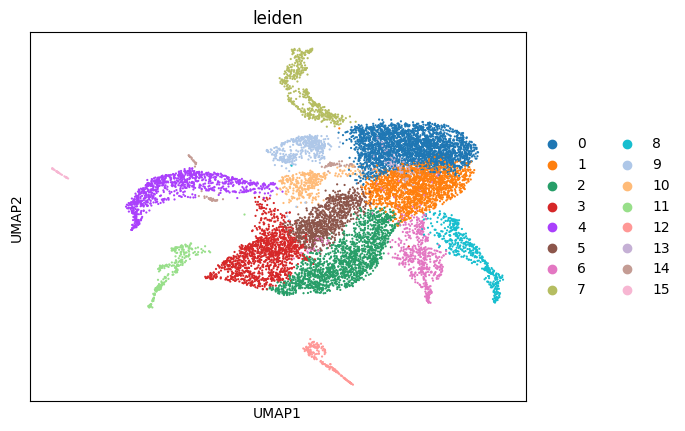

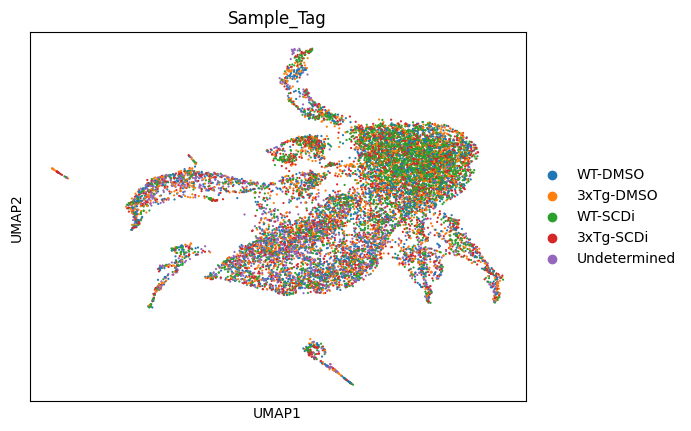

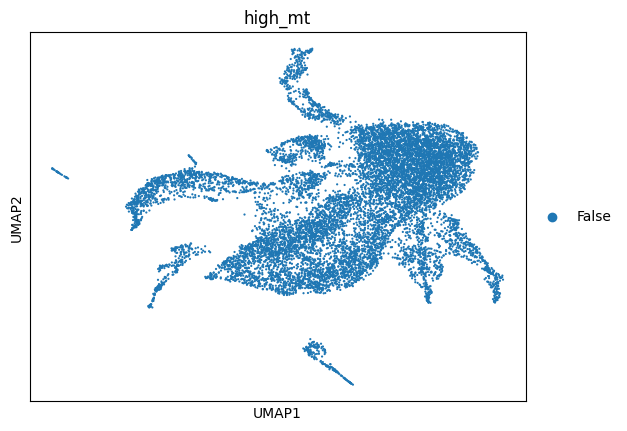

In [18]:
sc.pl.umap(adata, color=['leiden'], save='_leiden.png')
sc.pl.umap(adata, color=['Sample_Tag'], save='_sample_tag.png')
sc.pl.umap(adata, color=['high_mt'], save='_high_mt.png')

# Cluster annotation

In [19]:
assign_unique_cell_type_names(adata, cluster_key='leiden', cluster_types=['class_name', 'subclass_name'])

# Cluster visualization

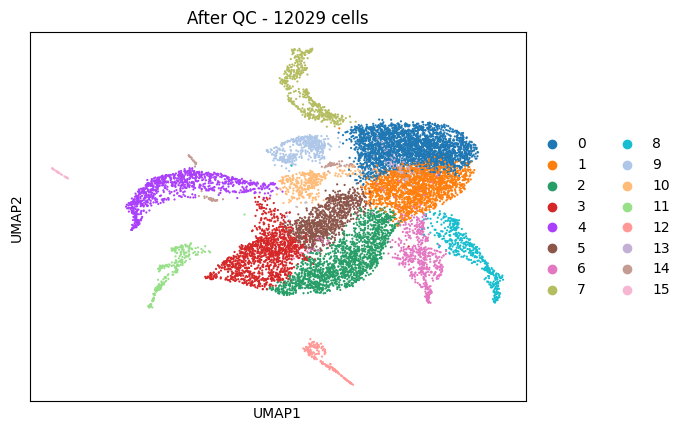

In [20]:
sc.pl.umap(adata, color=['leiden'], save='_cluster_anno.png', title=f'After QC - {adata.shape[0]} cells', size=10)

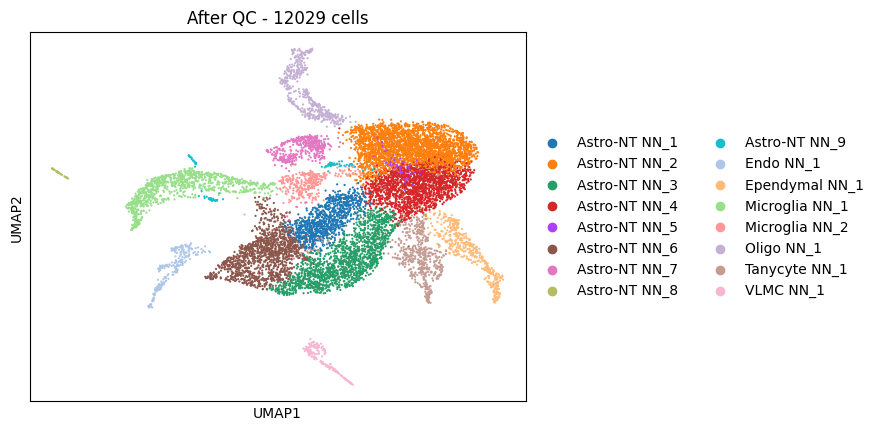

In [21]:
sc.pl.umap(adata, color=['cluster_subclass_name'], save='_subcluster_anno.png', title=f'After QC - {adata.shape[0]} cells', size=10)

/mnt/c/Users/Xavier/Desktop/sc_alz/myenv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


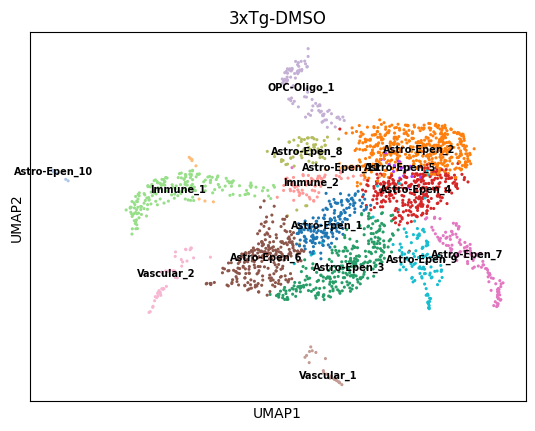

/mnt/c/Users/Xavier/Desktop/sc_alz/myenv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


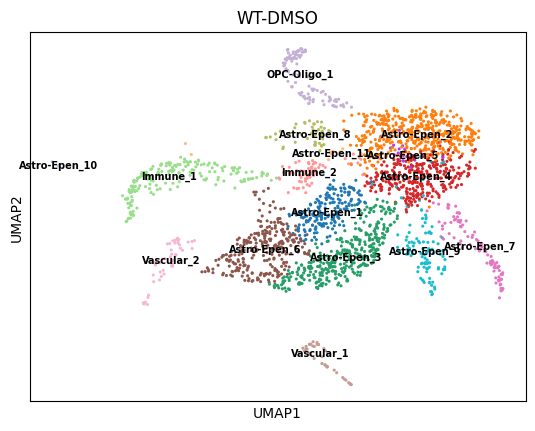

/mnt/c/Users/Xavier/Desktop/sc_alz/myenv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


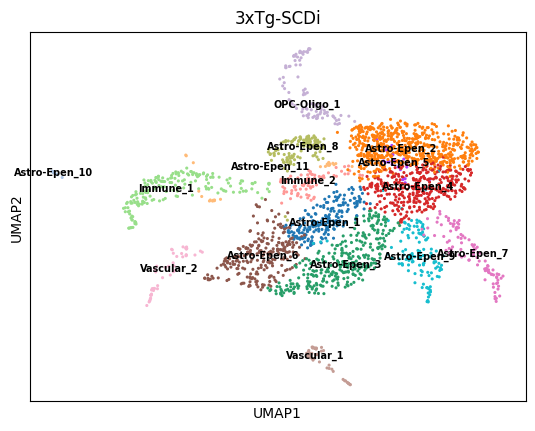

/mnt/c/Users/Xavier/Desktop/sc_alz/myenv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


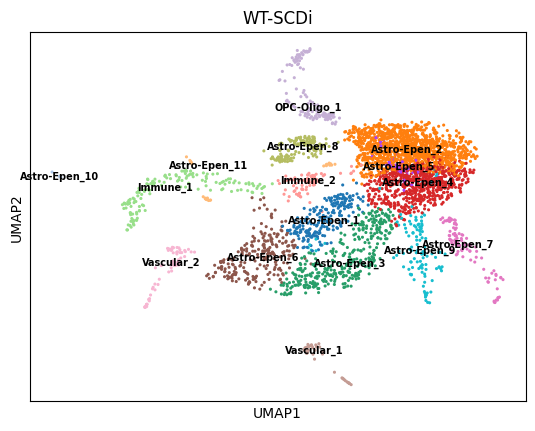

/mnt/c/Users/Xavier/Desktop/sc_alz/myenv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


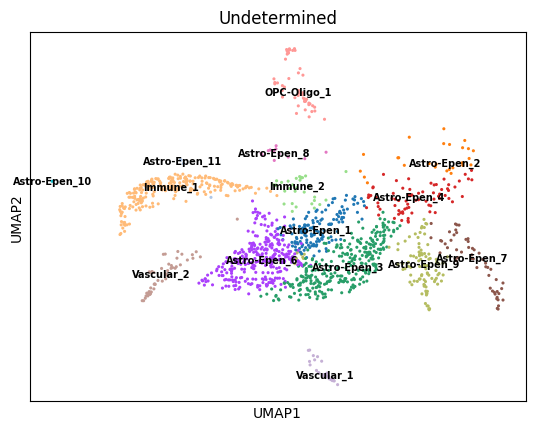

In [22]:
plot_umap(adata, cluster_type='cluster_class_name', legend_fontsize=7, save_path='_sample_tag')

# Keep only a specific cell type

In [ ]:
# filtered_obs = adata.obs[adata.obs['cluster_subclass_name'].str.startswith('Astro-NT NN')]
# filtered_indices = adata.obs.index.get_indexer(filtered_obs.index)
# filtered_adata = anndata.AnnData(
#     X=adata.raw.X[filtered_indices, :],
#     obs=filtered_obs.copy(),
#     var=adata.raw.var.copy(),
# )
# file_path = 'data/filtered_adata.h5ad'
# filtered_adata.write_h5ad(file_path)

# Master table

In [23]:
sample_tag_counts = get_master_table(adata, cluster_type='cluster_class_name', save_path='figures/master_table')

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = merged_df.groupby(cluster_type).size().reset_index(name='total_count')
/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_tag_counts = merged_df.groupby([cluster_type, 'Sample_Tag']).size().unstack(fill_value=0)


# Clusters composition analysis

In [24]:
class_level, cluster_type = 'class_name', 'cluster_class_name'

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


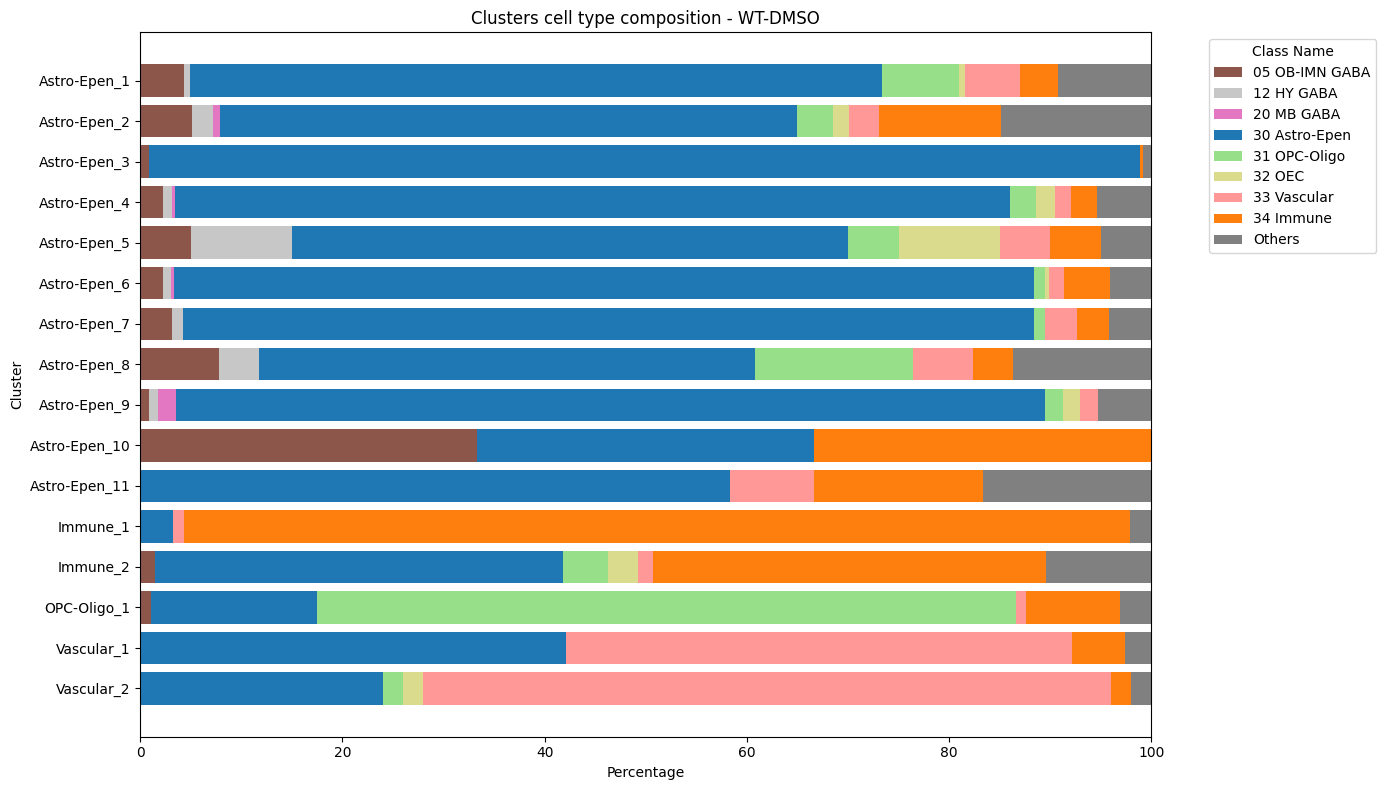

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


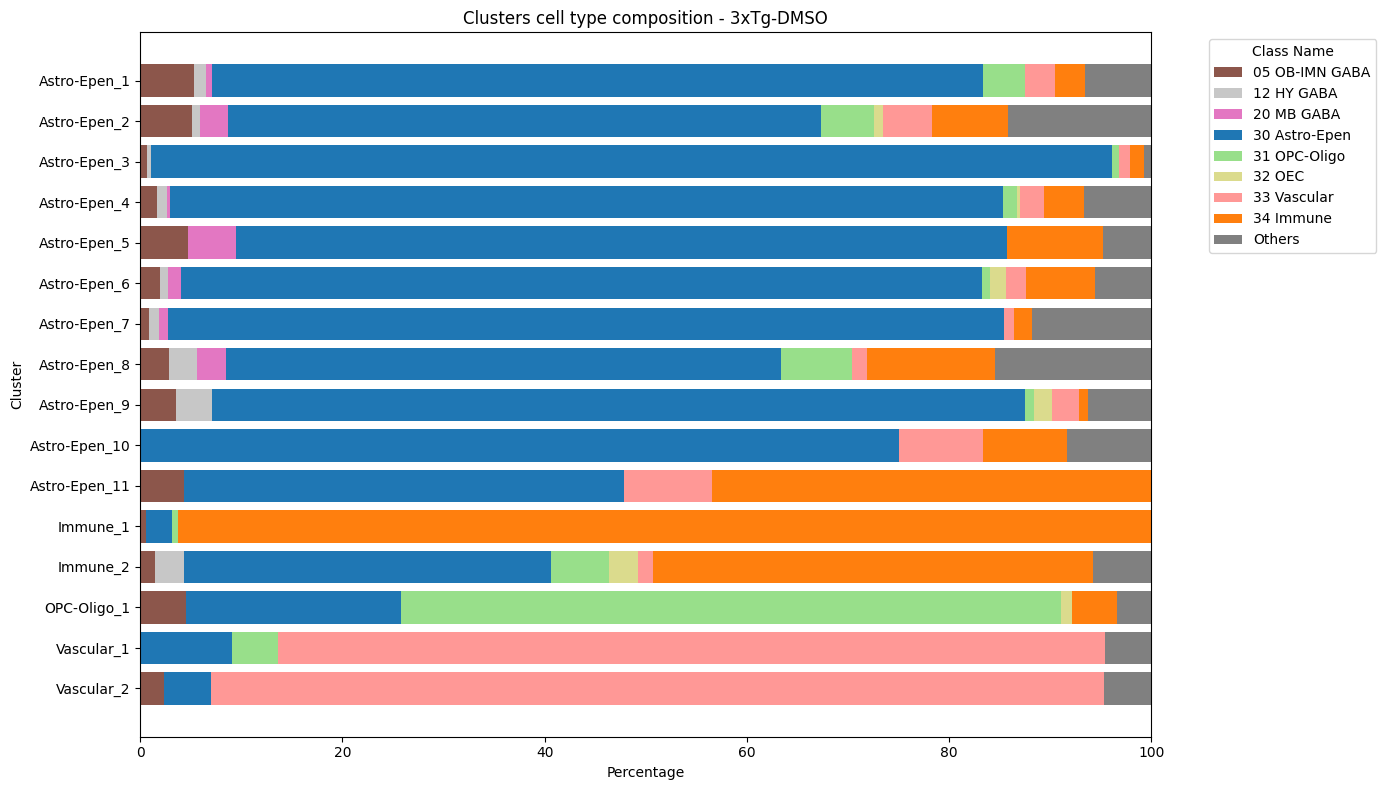

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


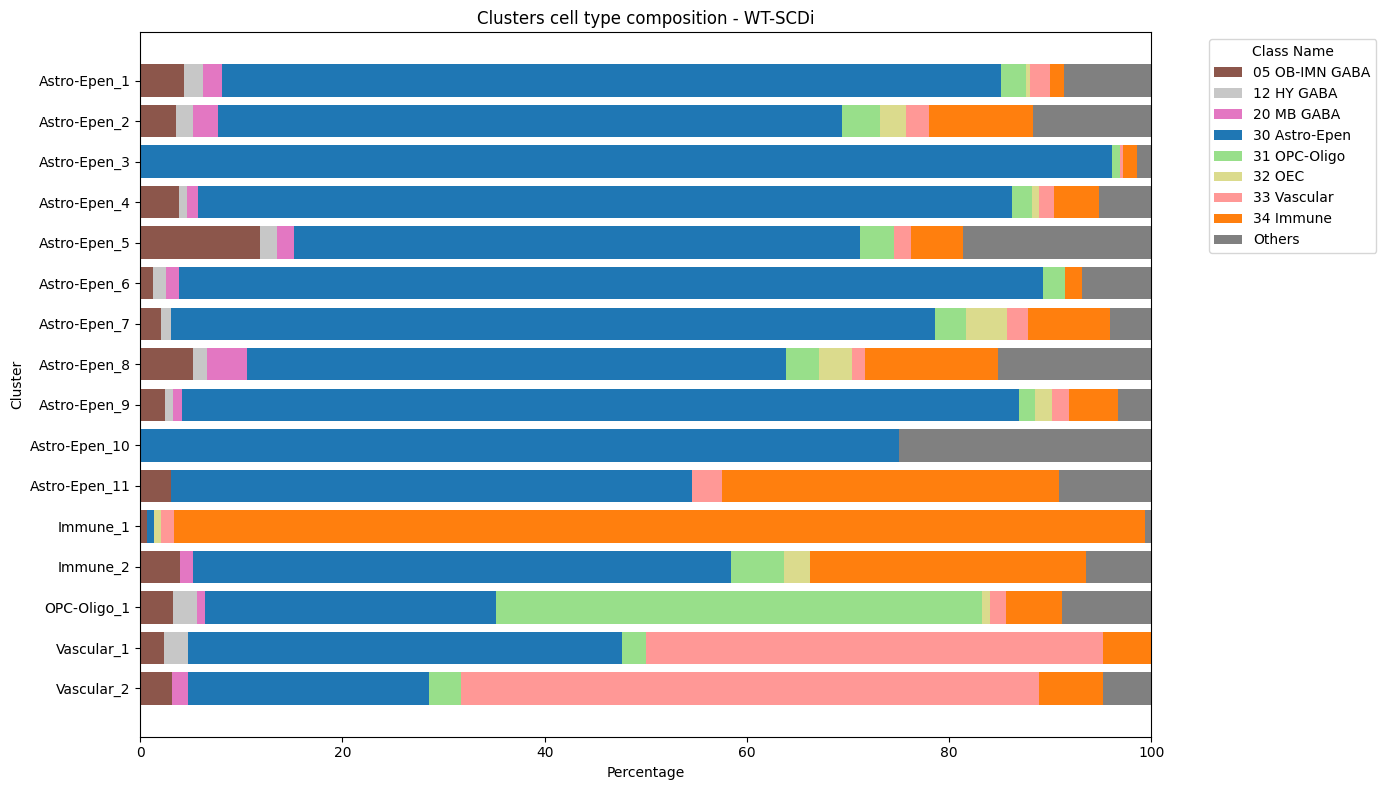

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


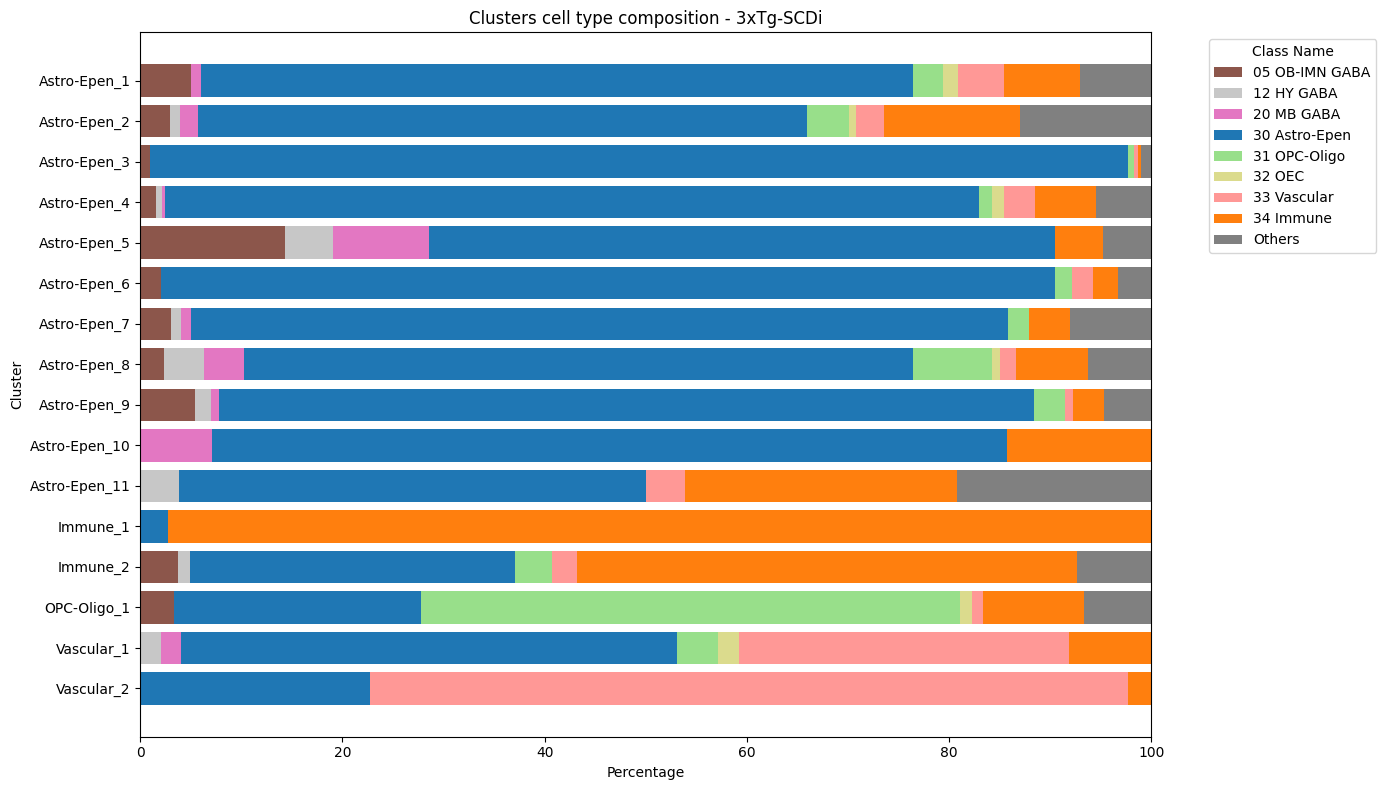

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[class_level] = df_filtered[class_level].apply(lambda x: x if x in valid_classes else 'Others')
/mnt/c/Users/Xavier/Desktop/sc_alz/modules/visualize.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


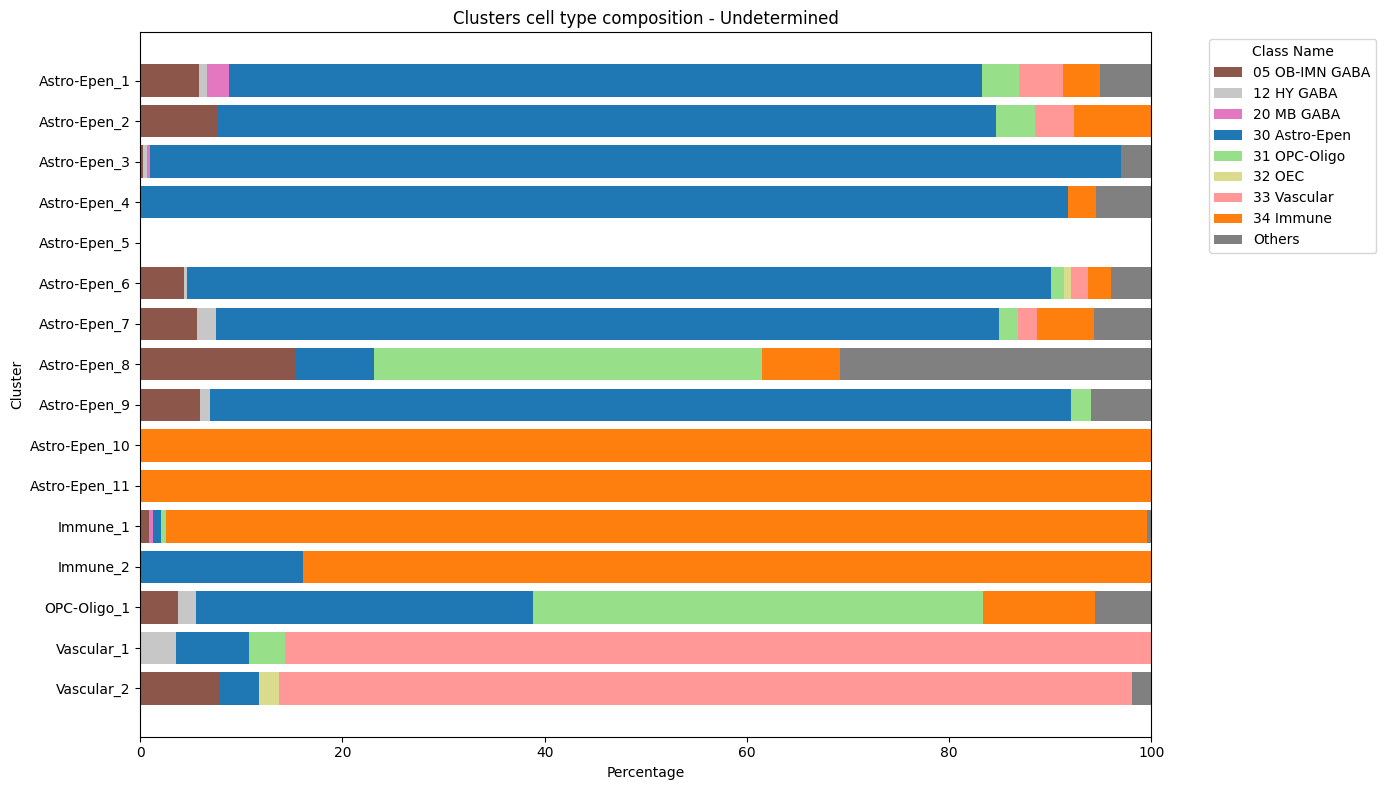

In [25]:
#create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['WT-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/wt_dmso_ditto.png')
create_ditto_plot(adata, ['3xTg-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/3xtg_dmso_ditto.png')
create_ditto_plot(adata, ['WT-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/wt_scdi_ditto.png')
create_ditto_plot(adata, ['3xTg-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/3xtg_scdi_ditto.png')
create_ditto_plot(adata, ['Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/undetermined_ditto.png')

# DEG analysis

In [60]:
ctr_cell_types = [x for x in set(adata.obs.cluster_class_name.values) if x.startswith('Astro-Epen') and x != 'Immune_1']
cnd_cell_types = [x for x in set(adata.obs.cluster_class_name.values) if x == 'Immune_1']
ctr_sample_tags = [x for x in set(adata.obs.Sample_Tag.values)]
cnd_sample_tags = [x for x in set(adata.obs.Sample_Tag.values)]

ctr_idx = adata[(adata.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata.obs['cluster_class_name'].isin(ctr_cell_types))].obs.index
cnd_idx = adata[(adata.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata.obs['cluster_class_name'].isin(cnd_cell_types))].obs.index

ctr_name = 'ctr'
cnd_name = 'cnd'

adata.obs['group'] = ['control' if i in ctr_idx else 'condition' if i in cnd_idx else 'undefined' for i in adata.obs.index]

In [ ]:
horizontal_deg_chart(adata,
                     min_fold_change=0.25,
                     max_p_value=0.05,
                     fig_title='ctr vs cnd',
                     save_path=f'figures/{ctr_name}_{cnd_name}_horizontal_deg_chart.png')

In [61]:
results_df = DEG_analysis(adata,
                          save_path=f'figures/{ctr_name}_{cnd_name}_results_df.pkl')

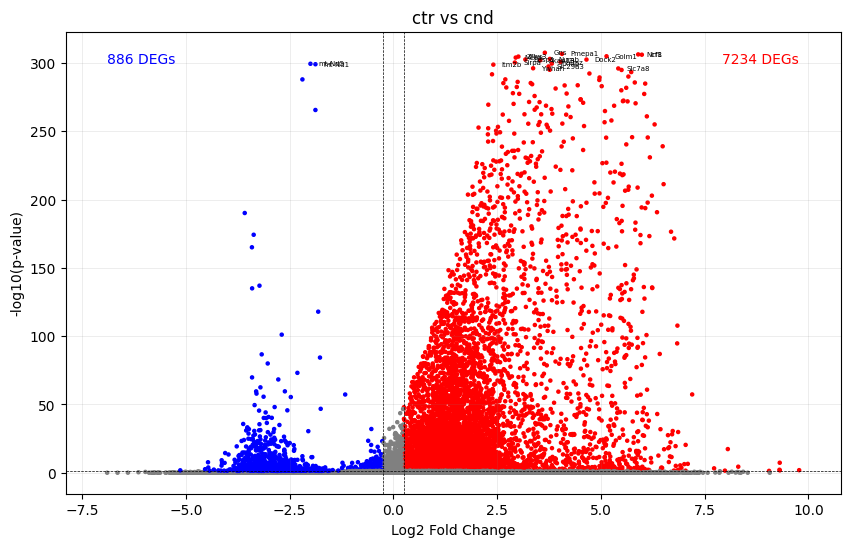

In [62]:
volcano_plot(results_df, 
             min_fold_change=0.25,
             max_p_value=0.05, 
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

# GO term enrichment analysis

In [63]:
UP_genes_name, DOWN_genes_name = get_DEGs(results_df,
                                          max_pval=0.05,
                                          min_fold_change=0.25)

In [64]:
UP_GO = go_enrichment_analysis(UP_genes_name, save_path=f'figures/{ctr_name}_{cnd_name}__GO_enrichment_analysis_UP.pkl')
DOWN_GO = go_enrichment_analysis(DOWN_genes_name, save_path=f'figures/{ctr_name}_{cnd_name}__GO_enrichment_analysis_DOWN.pkl')

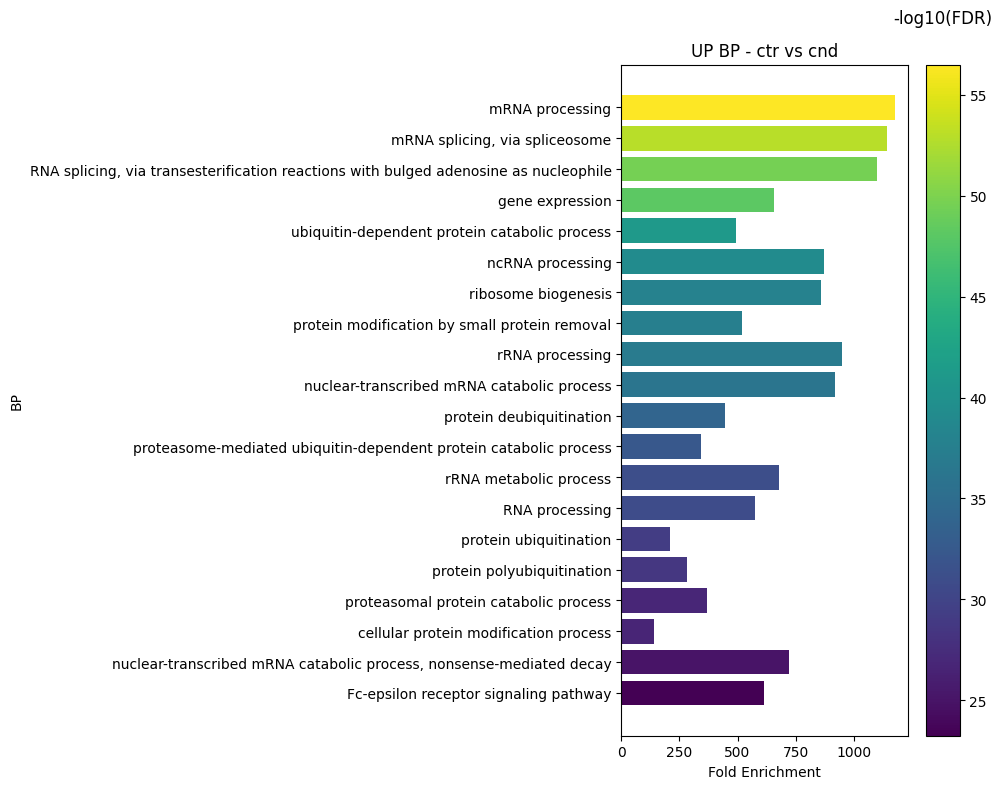

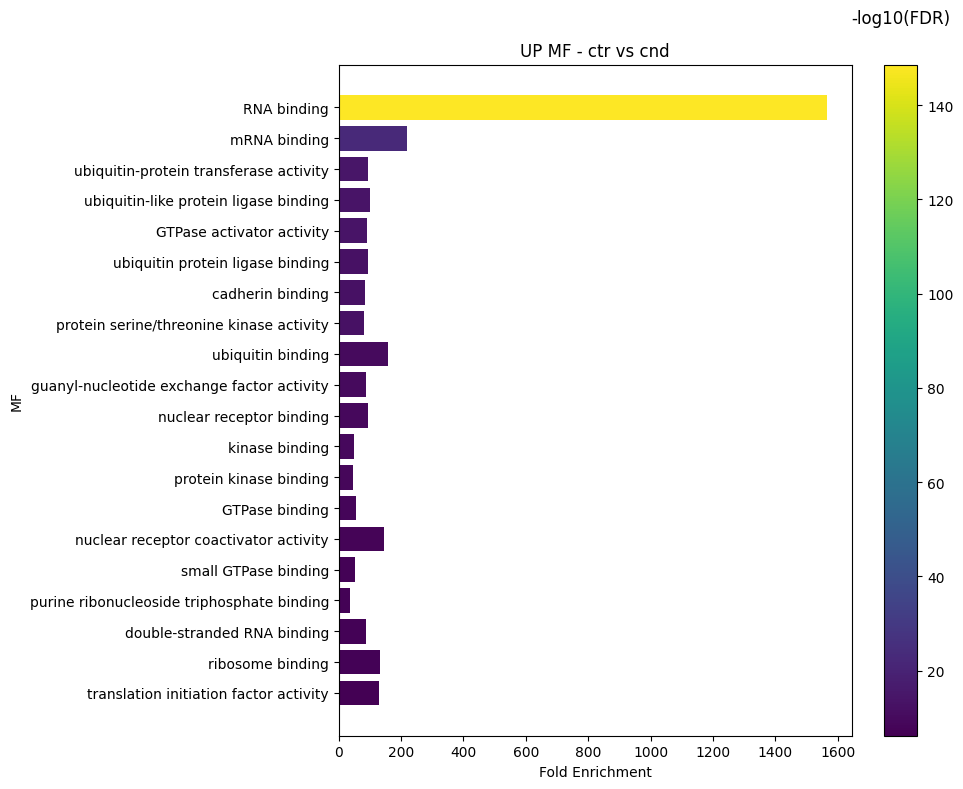

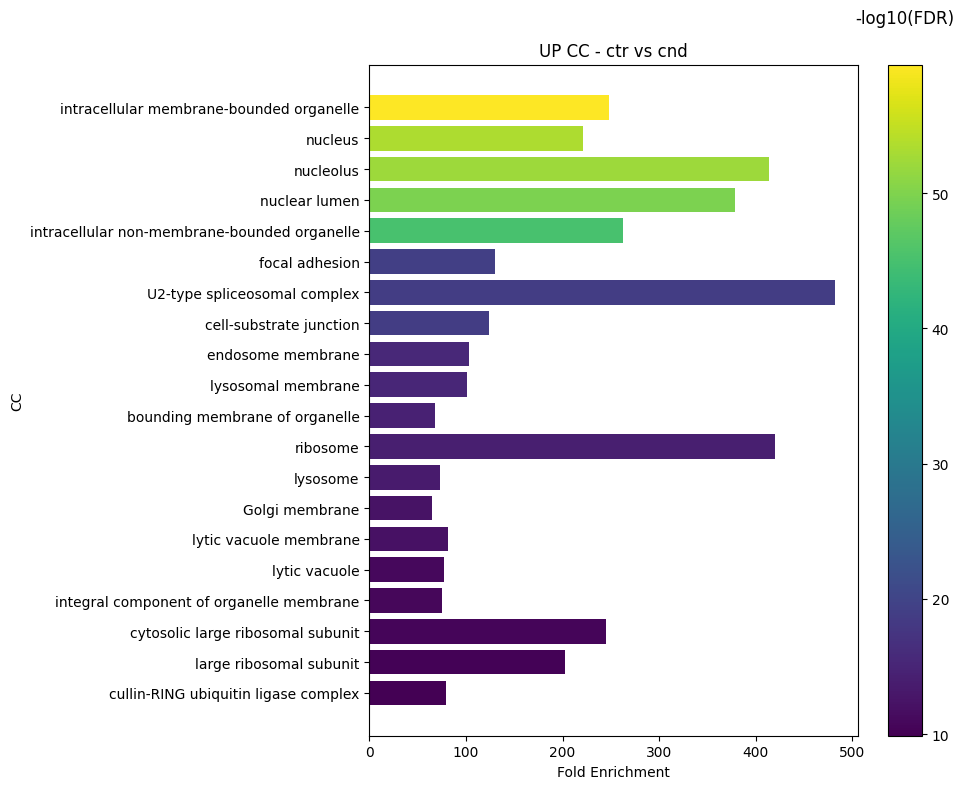

In [65]:
display_go_enrichment(UP_GO,
                      namespace='BP',
                      fig_title=f'UP BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_BP')

display_go_enrichment(UP_GO, 
                      namespace='MF',
                      fig_title=f'UP MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_MF')

display_go_enrichment(UP_GO, 
                      namespace='CC',
                      fig_title=f'UP CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_CC')

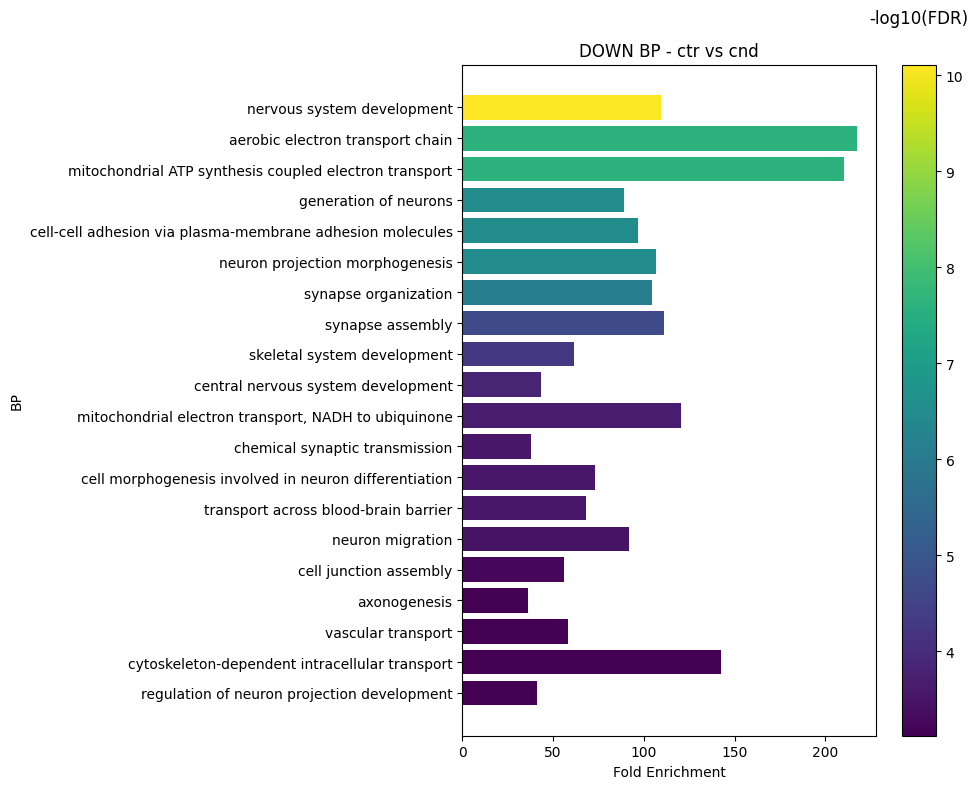

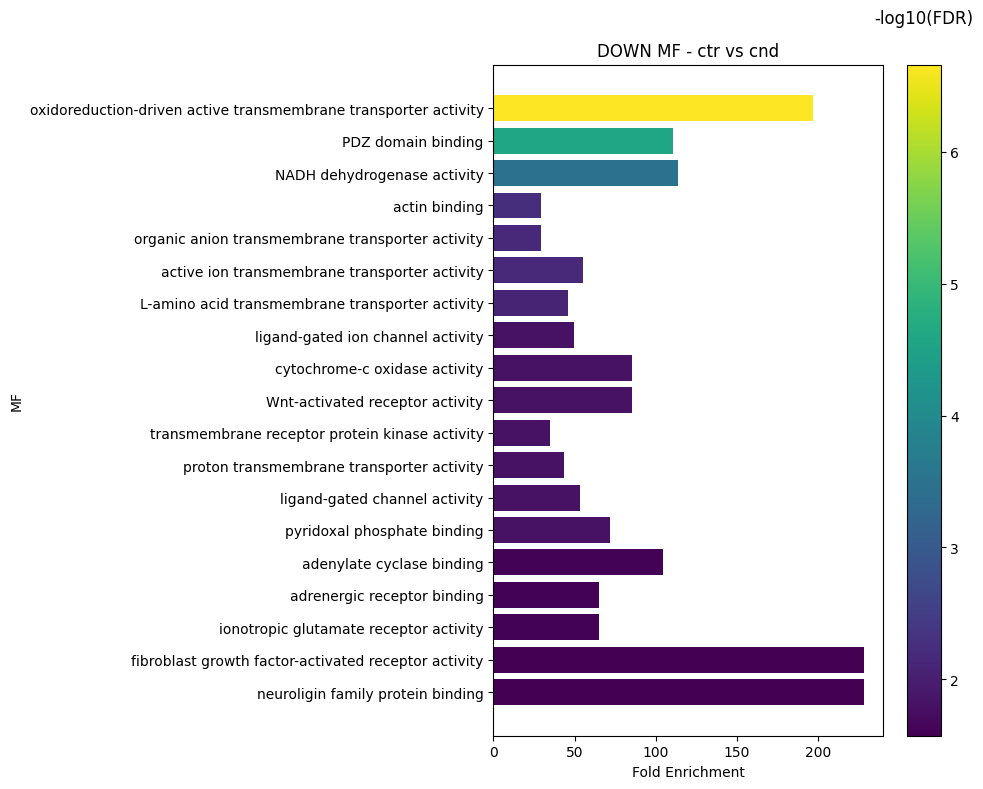

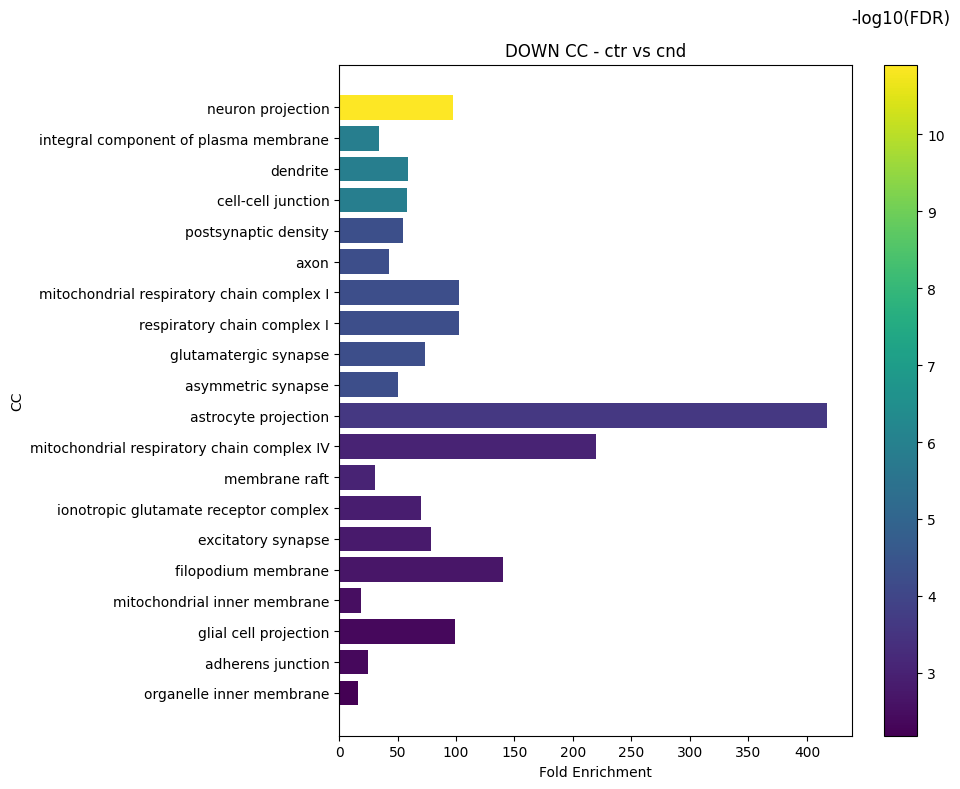

In [66]:
display_go_enrichment(DOWN_GO, 
                      namespace='BP',
                      fig_title=f'DOWN BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_BP')

display_go_enrichment(DOWN_GO, 
                      namespace='MF',
                      fig_title=f'DOWN MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_MF')

display_go_enrichment(DOWN_GO, 
                      namespace='CC',
                      fig_title=f'DOWN CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_CC')

In [67]:
UP_KEGG = kegg_enrichment_analysis(UP_genes_name, 
                                   save_path=f'figures/{ctr_name}_{cnd_name}_KEGG_enrichment_analysis.pkl')

In [68]:
DOWN_KEGG = kegg_enrichment_analysis(DOWN_genes_name, 
                                     save_path=f'figures/{ctr_name}_{cnd_name}_KEGG_enrichment_analysis.pkl')

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/deg_analysis.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(FDR)'] = -np.log10(df['p_fdr_bh'])


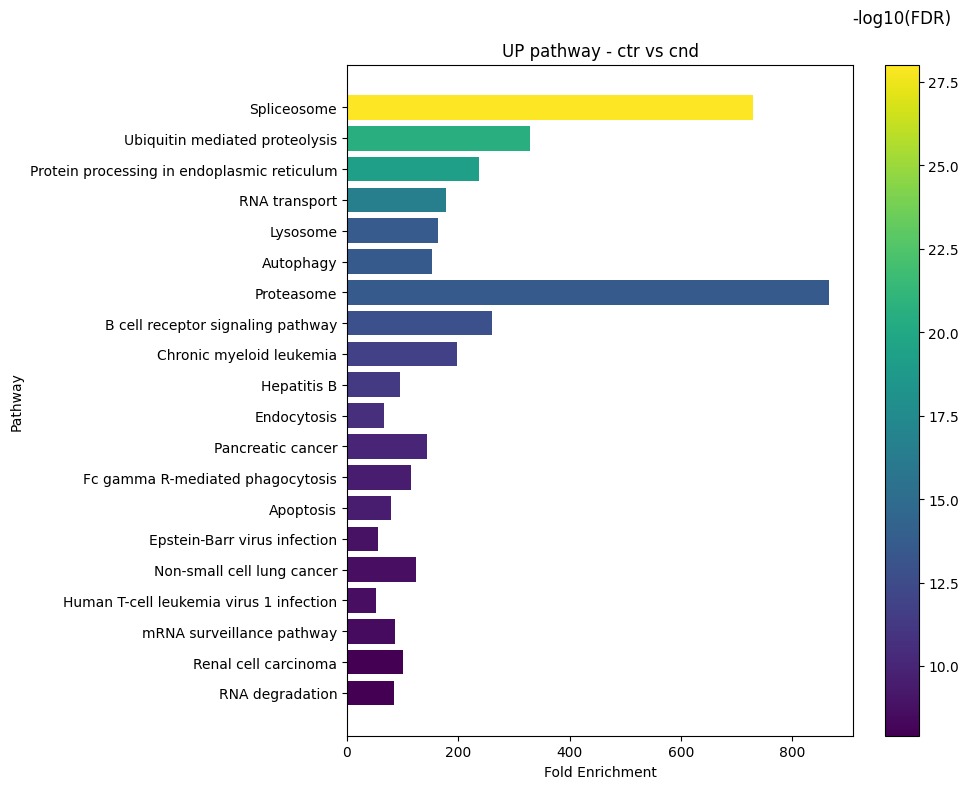

In [69]:
display_kegg_enrichment(UP_KEGG,
                        fig_title=f'UP pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_UP')

/mnt/c/Users/Xavier/Desktop/sc_alz/modules/deg_analysis.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(FDR)'] = -np.log10(df['p_fdr_bh'])


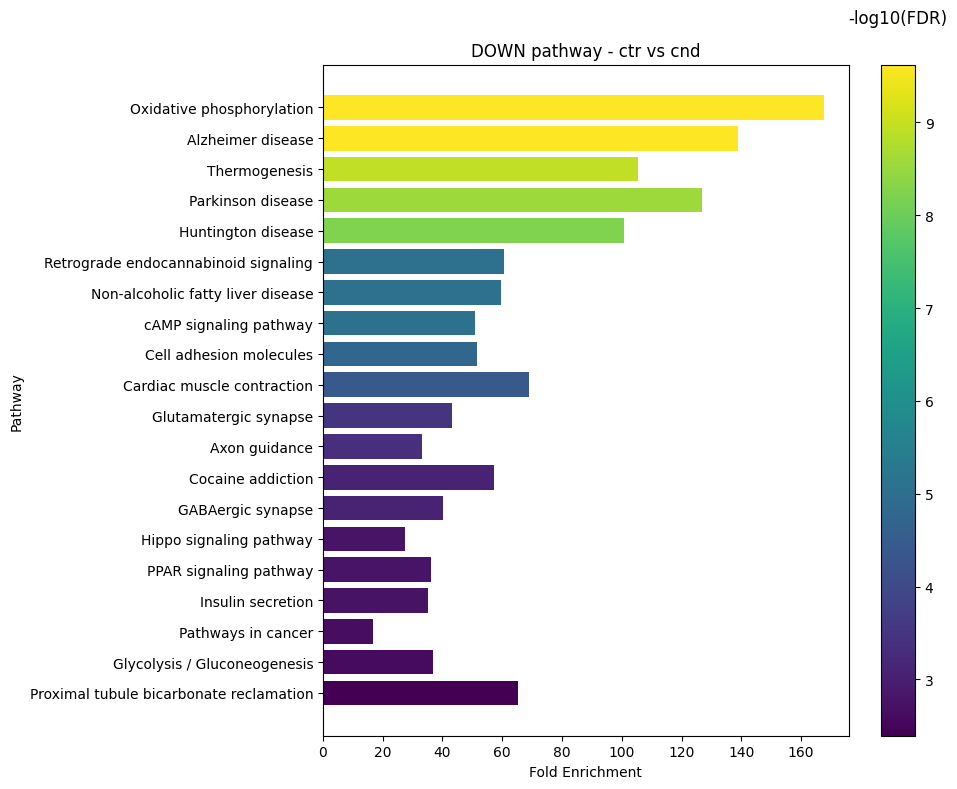

In [70]:
display_kegg_enrichment(DOWN_KEGG,
                        fig_title=f'DOWN pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_DOWN')